First models were trained at this notebook. The try/except methods were used to understand our mistakes while creting the models. The model was trained but seen that the vaalidation dataset ws unbalanced. The results of model were tested with different dataset.

In [13]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import numpy as np
from PIL import Image

# Received so many errors while trying, because of that try except was used
try:
    from torchvision.io import read_video
except ImportError:
    raise ImportError("PyAV is not installed. Install it using: pip install av")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

# Dataset Preparation
class VideoDataset(Dataset):
    def __init__(self, folder_path, metadata_path, transform=None, num_frames=5):
        self.folder_path = folder_path
        self.transform = transform
        self.num_frames = num_frames
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        self.videos = list(self.metadata.keys())

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_name = self.videos[idx]
        video_path = os.path.join(self.folder_path, video_name)
        label = 1 if self.metadata[video_name]['label'] == 'FAKE' else 0

        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()
        while success and len(frames) < self.num_frames:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            success, frame = cap.read()
        cap.release()

        while len(frames) < self.num_frames:
            frames.append(torch.zeros((3, 224, 224)))

        frames = torch.stack(frames[:self.num_frames])
        return frames, torch.tensor(label, dtype=torch.float32)

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Loading datasets
metadata_path = r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_videos\\metadata.json"
train_dataset = VideoDataset(r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_videos", metadata_path, transform=transform, num_frames=5)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)

class FakeVideoDetector(nn.Module):
    def __init__(self):
        super(FakeVideoDetector, self).__init__()
        self.resnet = resnet18(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        # Input shape: (B, F, C, H, W) -> ResNet processes single images
        B, F, C, H, W = x.size()
        x = x.view(B * F, C, H, W)  
        x = self.resnet(x)
        x = x.view(B, F, -1).mean(dim=1) 
        return x

# Initialize model, loss, optimizer
model = FakeVideoDetector().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Device used: cuda
Epoch 1, Loss: 0.5973
Epoch 2, Loss: 0.4862
Epoch 3, Loss: 0.4772
Epoch 4, Loss: 0.4515
Epoch 5, Loss: 0.4693
Epoch 6, Loss: 0.4552
Epoch 7, Loss: 0.4150
Epoch 8, Loss: 0.3871
Epoch 9, Loss: 0.4020
Epoch 10, Loss: 0.3743


In [14]:
torch.save(model.state_dict(), "fake_video_detector.pth")
print("Model saved successfully.")


Model saved successfully.


In [15]:
model.eval() 

FakeVideoDetector(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

C:\Users\yakup\AppData\Local\Temp\ipykernel_6028\2276947653.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_video_detector.pth"))


Classification Report:

              precision    recall  f1-score   support

        REAL       0.75      0.50      0.60        18
        FAKE       0.87      0.95      0.91        62

    accuracy                           0.85        80
   macro avg       0.81      0.73      0.75        80
weighted avg       0.84      0.85      0.84        80



<Figure size 800x600 with 0 Axes>

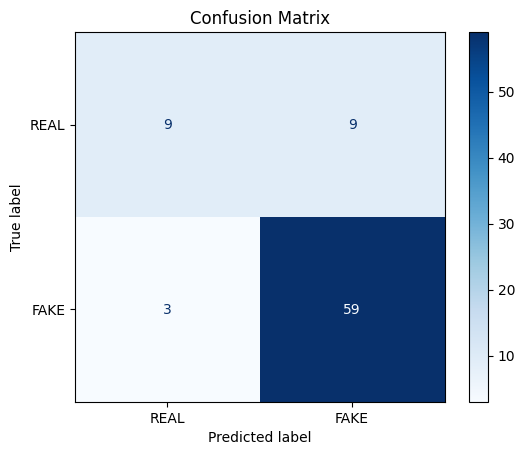

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and gather predictions and true labels
model.load_state_dict(torch.load("fake_video_detector.pth"))
model.eval()

all_preds = []
all_labels = []

# Perform evaluation
with torch.no_grad():
    for videos, labels in validation_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        preds = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and display classification report
report = classification_report(all_labels, all_preds, target_names=["REAL", "FAKE"])
print("Classification Report:\n")
print(report)

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [22]:
import cv2
import os
import torch
from torchvision.transforms import transforms
from PIL import Image

# Define the test folder path
test_folder = r"C:/Users/yakup/OneDrive/Desktop/Special Dataset/test_videos"

# Function to preprocess video frames
def preprocess_video(video_path, transform, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success and len(frames) < num_frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame) 
        frame = transform(frame)
        frames.append(frame)
        success, frame = cap.read()
    cap.release()

    while len(frames) < num_frames:
        frames.append(torch.zeros((3, 224, 224)))

    frames = torch.stack(frames[:num_frames])
    return frames.unsqueeze(0)  

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Loading the trained model
model.load_state_dict(torch.load("fake_video_detector.pth"))
model.eval()

# Predicting for each video
print("Predictions for test videos:\n")
for video_name in os.listdir(test_folder):
    video_path = os.path.join(test_folder, video_name)
    if not video_path.lower().endswith(('.mp4', '.avi', '.mov')):  
        continue

    try:
        # Preprocess video
        video_tensor = preprocess_video(video_path, transform).to(device)

        # Predict using the model
        with torch.no_grad():
            output = model(video_tensor)
            pred = (torch.sigmoid(output.squeeze()) > 0.5).int().item()

        # Mapping prediction to label
        label = "FAKE" if pred == 1 else "REAL"
        print(f"{video_name}: {label}")

    except Exception as e:
        print(f"Error processing {video_name}: {e}")


C:\Users\yakup\AppData\Local\Temp\ipykernel_6028\3218452450.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_video_detector.pth"))

Predictions for test videos:

aassnaulhq.mp4: FAKE
aayfryxljh.mp4: FAKE
acazlolrpz.mp4: FAKE
adohdulfwb.mp4: FAKE
ahjnxtiamx.mp4: FAKE
ajiyrjfyzp.mp4: FAKE
aktnlyqpah.mp4: FAKE
alrtntfxtd.mp4: FAKE
aomqqjipcp.mp4: FAKE
apedduehoy.mp4: FAKE
apvzjkvnwn.mp4: FAKE
aqrsylrzgi.mp4: FAKE
axfhbpkdlc.mp4: FAKE
ayipraspbn.mp4: FAKE
bcbqxhziqz.mp4: FAKE
bcvheslzrq.mp4: FAKE
bdshuoldwx.mp4: FAKE
bfdopzvxbi.mp4: FAKE
bfjsthfhbd.mp4: FAKE
bjyaxvggle.mp4: FAKE
bkcyglmfci.mp4: FAKE
bktkwbcawi.mp4: FAKE
bkuzquigyt.mp4: FAKE
blnmxntbey.mp4: FAKE
blszgmxkvu.mp4: FAKE
bnuwxhfahw.mp4: FAKE
bofrwgeyjo.mp4: FAKE
btdxnajogv.mp4: FAKE
bvpeerislp.mp4: FAKE
bwdmzwhdnw.mp4: FAKE
bzvzpwrabw.mp4: FAKE
cekarydqba.mp4: FAKE
cekwtyxdoo.mp4: FAKE
cjkctqqakb.mp4: FAKE
cnpanmywno.mp4: FAKE
cnxccbjlct.mp4: FAKE
coqwgzpbhx.mp4: FAKE
cosghhimnd.mp4: FAKE
coujjnypba.mp4: FAKE
cqhwesrciw.mp4: FAKE
cqxxumarvp.mp4: FAKE
csnkohqxdv.mp4: FAKE
cxsvvnxpyz.mp4: FAKE
czfqlbcfpa.mp4: FAKE
dcqodpzomd.mp4: FAKE
ddtbarpcgo.mp4: FAKE
demu